# Read dataset

In [1]:
import pandas as pd

In [2]:
customer_data = pd.read_csv('D:/DATA/Desktop/bigData/final_project/work/data/Churn_Modelling_FE.csv')

# Droping the ineffective columns
dataset = customer_data.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)
df_fe = dataset
df_fe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalary,...,age_balance,balance_salary,age_hascrcard,product_utilization_rate_by_year,product_utilization_rate_by_salary,countries_monthly_average_salaries,Germany,Spain,Female,Male
0,619,42,2,0.00,1,1,1,101348.88,1,0.000000,...,0.000000,0.000000,0.023810,0.500,0.000010,2.285103,False,False,True,False
1,608,41,1,83807.86,1,0,1,112542.58,0,0.744677,...,2044.094146,0.744677,0.000000,1.000,0.000009,4.155316,False,True,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,1.401375,...,3801.447619,1.401375,0.023810,0.375,0.000026,2.568803,False,False,True,False
3,699,39,1,0.00,2,0,0,93826.63,0,0.000000,...,0.000000,0.000000,0.000000,2.000,0.000021,2.115499,False,False,True,False
4,850,43,2,125510.82,1,1,1,79084.10,0,1.587055,...,2918.856279,1.587055,0.023256,0.500,0.000013,2.919956,False,True,True,False


# Separate features and label and scaling data

In [3]:
from sklearn.preprocessing import StandardScaler

# Data inputs
X = df_fe.drop(['Exited'], axis = 1)
m = X

# Feature Scaling
sc = StandardScaler()
X = sc.fit_transform(X)
X = pd.DataFrame(X)
X.columns = m.columns

# Data outputs
Y = df_fe['Exited']

# Devide train and test and scaling dataset

In [4]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7654, 32) (1914, 32) (7654,) (1914,)


# Balancing the samples

In [5]:
from collections import Counter
from imblearn.over_sampling import SMOTEN

sm = SMOTEN()
X_smot_train, Y_smot_train = sm.fit_resample(X_train, y_train)
X_smot_test, Y_smot_test = sm.fit_resample(X_test, y_test)

print('Original dataset shape(Train): ', Counter(y_train))
print('Resampled dataset shape(Train): ', Counter(Y_smot_train))
print('\nOriginal dataset shape(Test): ', Counter(y_test))
print('Resampled dataset shape(Test): ', Counter(Y_smot_test))

Original dataset shape(Train):  Counter({0: 6106, 1: 1548})
Resampled dataset shape(Train):  Counter({0: 6106, 1: 6106})

Original dataset shape(Test):  Counter({0: 1571, 1: 343})
Resampled dataset shape(Test):  Counter({1: 1571, 0: 1571})


# GCN

In [9]:
import torch
import pandas as pd
import numpy as np
from sklearn.neighbors import kneighbors_graph
from torch_geometric.data import Data

# covert to numpy
train_x = torch.tensor(X_smot_train.values, dtype=torch.float)
test_x = torch.tensor(X_smot_test.values, dtype=torch.float)

train_y = torch.tensor(Y_smot_train.values, dtype=torch.long)
test_y = torch.tensor(Y_smot_test.values, dtype=torch.long)

# Define edges using k-NN (Example: k=5)
def define_edges(x, k):
    adj_matrix = kneighbors_graph(x, k, mode='connectivity', include_self=False)
    edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)
    return edge_index


train_edge_index = define_edges(train_x, 9)
test_edge_index = define_edges(test_x, 9)

# Create PyTorch Geometric Graph Data
train_graph_data = Data(x=train_x, edge_index=train_edge_index)
test_graph_data = Data(x=test_x, edge_index=test_edge_index)
print(train_graph_data)
print(test_graph_data)

# create instance of PyTorch Geometric 
train_data = Data(x=train_x, edge_index=train_edge_index, y=train_y)
test_data = Data(x=test_x, edge_index=test_edge_index, y=test_y)

Data(x=[12212, 32], edge_index=[2, 109908])
Data(x=[3142, 32], edge_index=[2, 28278])


In [10]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_features, hidden_dim, out_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Instantiate Model
model = GCN(in_features=train_x.shape[1], hidden_dim=16, out_classes=2)  

Epoch: 001, Accuracy: 0.7365, Precision: 0.7401, Recall: 0.7365, F1-score: 0.7355
Epoch: 002, Accuracy: 0.7944, Precision: 0.7944, Recall: 0.7944, F1-score: 0.7944
Epoch: 003, Accuracy: 0.8116, Precision: 0.8129, Recall: 0.8116, F1-score: 0.8114
Epoch: 004, Accuracy: 0.8291, Precision: 0.8312, Recall: 0.8291, F1-score: 0.8288
Epoch: 005, Accuracy: 0.8440, Precision: 0.8465, Recall: 0.8440, F1-score: 0.8438
Epoch: 006, Accuracy: 0.8504, Precision: 0.8517, Recall: 0.8504, F1-score: 0.8503
Epoch: 007, Accuracy: 0.8596, Precision: 0.8602, Recall: 0.8596, F1-score: 0.8596
Epoch: 008, Accuracy: 0.8631, Precision: 0.8633, Recall: 0.8631, F1-score: 0.8631
Epoch: 009, Accuracy: 0.8689, Precision: 0.8689, Recall: 0.8689, F1-score: 0.8689
Epoch: 010, Accuracy: 0.8733, Precision: 0.8736, Recall: 0.8733, F1-score: 0.8733
Epoch: 011, Accuracy: 0.8787, Precision: 0.8796, Recall: 0.8787, F1-score: 0.8787
Epoch: 012, Accuracy: 0.8826, Precision: 0.8843, Recall: 0.8826, F1-score: 0.8824
Epoch: 013, Accu

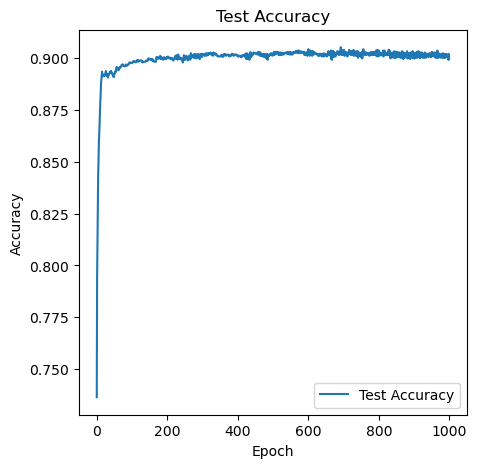

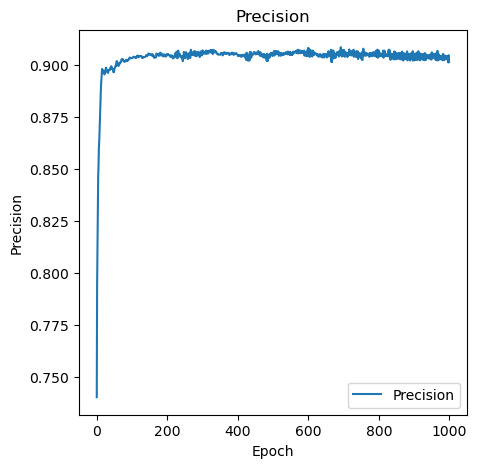

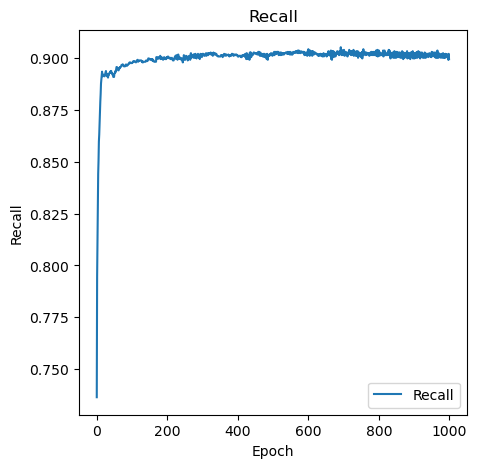

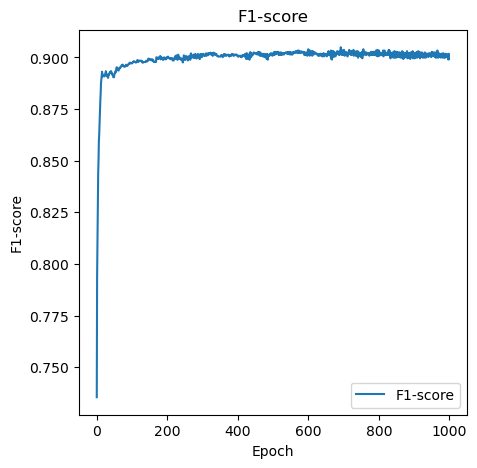

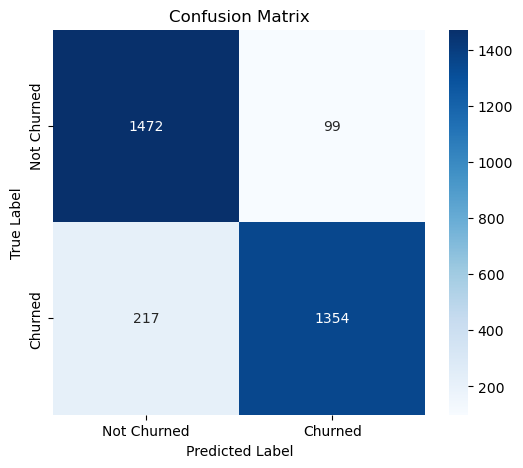

In [11]:
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Initialize lists to store the results
test_accuracies = []
precisions = []
recalls = []
f1_scores = []

def train():
    model.train()
    optimizer.zero_grad()
    out = model(train_data.x, train_data.edge_index)
    loss = criterion(out, train_data.y.squeeze())
    loss.backward()
    optimizer.step()
    
    

def test():
    model.eval()
    out = model(test_data.x, test_data.edge_index)
    pred = out.argmax(dim=1)
    correct = int(pred.eq(test_data.y.squeeze()).sum().item())
    acc = correct / len(test_data.y)
    precision = precision_score(test_data.y.squeeze().cpu(), pred.cpu(), average='macro')
    recall = recall_score(test_data.y.squeeze().cpu(), pred.cpu(), average='macro')
    f1 = f1_score(test_data.y.squeeze().cpu(), pred.cpu(), average='macro')
    return acc, precision, recall, f1, pred


# Train and Test the model
for epoch in range(1, 1001):
    train()
    acc, precision, recall, f1, predictions = test()
    test_accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    print(f'Epoch: {epoch:03d}, Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

# Save the model
torch.save(model.state_dict(), 'D:/DATA/Desktop/bigData/final_project/work/models/GCN/gcn_model.pth')

# Find the best value of Accuracy, Precision, Recall và F1-score
best_accuracy = max(test_accuracies)
best_precision = max(precisions)
best_recall = max(recalls)
best_f1_score = max(f1_scores)

print(f'Best Accuracy: {best_accuracy:.4f}')
print(f'Best Precision: {best_precision:.4f}')
print(f'Best Recall: {best_recall:.4f}')
print(f'Best F1-score: {best_f1_score:.4f}')

# Visualize the Accuracy
plt.figure(figsize=(5, 5))
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualize the Precision
plt.figure(figsize=(5, 5))
plt.plot(precisions, label='Precision')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Visualize the  Recall 
plt.figure(figsize=(5, 5))
plt.plot(recalls, label='Recall')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

# Visualize the F1-score
plt.figure(figsize=(5, 5))
plt.plot(f1_scores, label='F1-score')
plt.title('F1-score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.legend()
plt.show()

# Visualize the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(test_data.y.squeeze().cpu(), predictions.cpu()), annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
